# Rice Chalkiness Tutorial

Analyze rice chalkiness in high throughput with the following workflow. Note, depending on image capture protocol, this workflow might need adjustments to work on new datasets. 


# Section 1: Importing Image and Libraries

In [1]:
# Set the notebook display method
# If widget is not working, then change to inline
%matplotlib widget

# Import libraries
import numpy as np
from plantcv import plantcv as pcv
from plantcv.parallel import WorkflowInputs

# Print out the version of PlantCV being used by the Jupyter kernel
pcv.__version__

'4.10.dev141+g4d773a24e'

## Input/Output variables

The options class mimics the workflow command-line argument parser that is used for workflow parallelization. Using it while developing a workflow in Jupyter makes it easier to convert the workflow to a script later. Remember, always keep your raw images separate from your newly processed images!

In [2]:
# Input/output options
args = WorkflowInputs(
    images=["img/rice-img.png"],
    names="image1",
    result="test.json",
    outdir=".",
    writeimg=True,
    debug="plot"
    )

In [3]:
# Set debug to the global parameter 
pcv.params.debug = args.debug
# Change display settings
pcv.params.dpi = 100
# Increase text size and thickness to make labels clearer
# (size may need to be altered based on original image size)
pcv.params.text_size = 5
pcv.params.text_thickness = 10

## Read the input image

### Reading images into your environment using *pcv.readimage()*
Inputs:
   * filename = Image file to be read in
   * mode     = How the image will be read into the notebook; either 'native' (default), 'rgb', 'gray', 'csv', or 'envi'

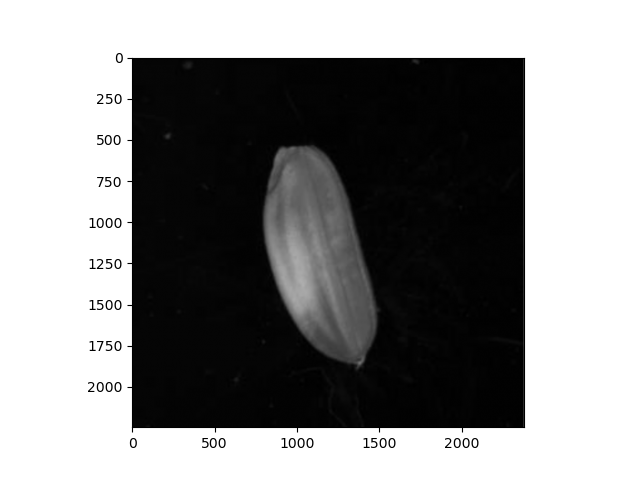

In [4]:
img, path, filename = pcv.readimage(filename=args.image1, mode='gray')

## Segment the rice

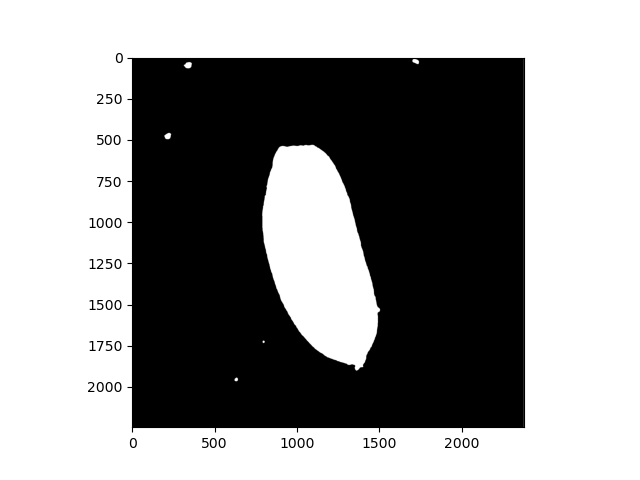

In [5]:
thresh = pcv.threshold.binary(gray_img=img, threshold=20, object_type="light")

## Clean the mask 

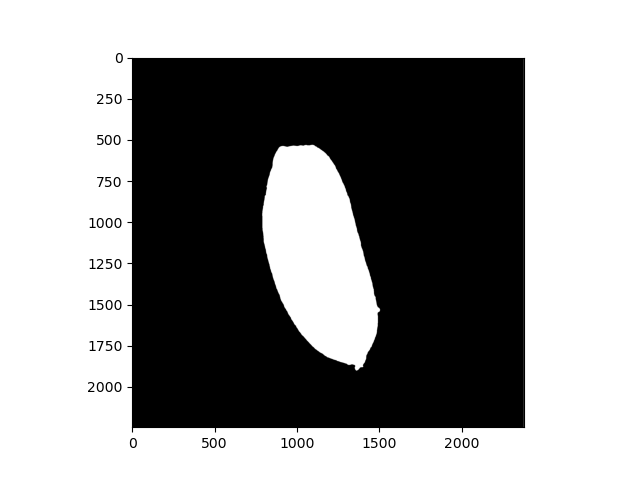

In [6]:
cleaned_mask = pcv.fill(bin_img=thresh, size=3000)

## Clean the mask with a Region Of Interest

This can help with removing a border in the seed mask. 

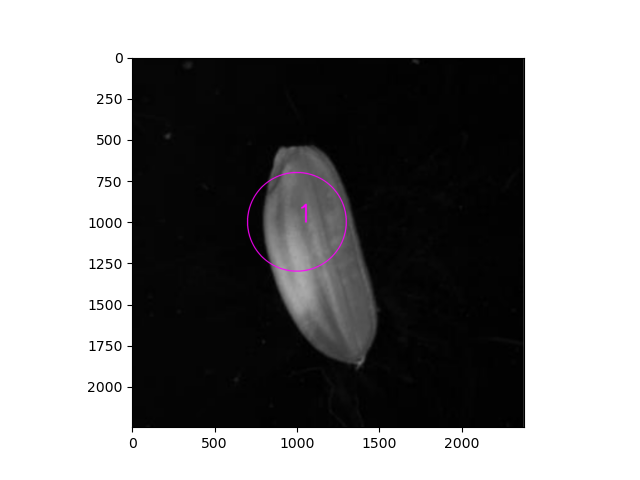

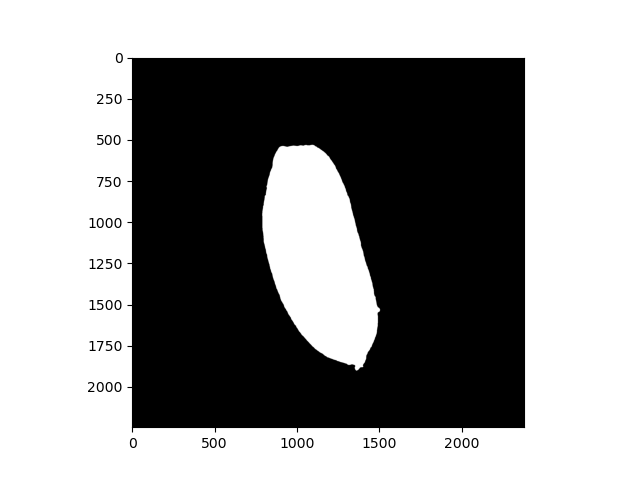

In [7]:
roi = pcv.roi.circle(img=img, x=1000, y=1000, r=300)
cleaned_mask = pcv.roi.filter(mask=cleaned_mask, roi=roi, roi_type='partial')

## Apply mask to input image


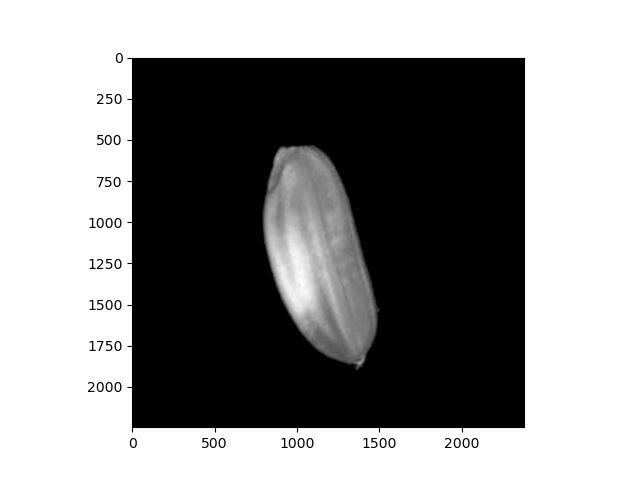

In [8]:
seed_img = pcv.apply_mask(img=img, mask=cleaned_mask, mask_color='black')


## Calculate median pixel intensity 
Decide on the chalkiness threshold based on median pixel intensity 

In [9]:
median_intensity = np.median(seed_img[np.where(seed_img > 0)])
chalk_threshold = median_intensity + 20

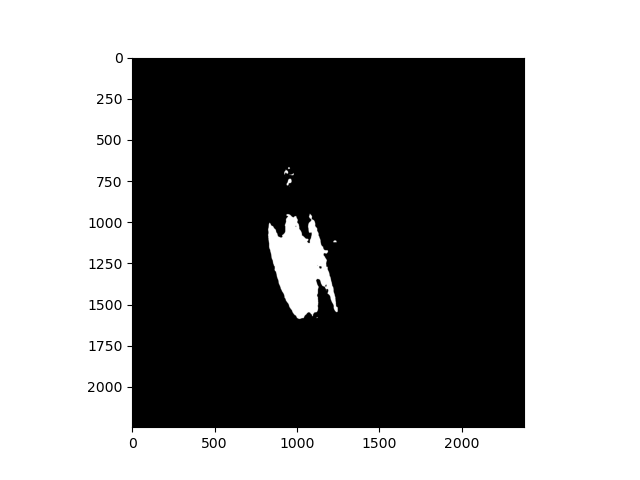

In [10]:
chalk = pcv.threshold.binary(gray_img=seed_img, threshold=chalk_threshold, object_type='light')

## Analyze size 


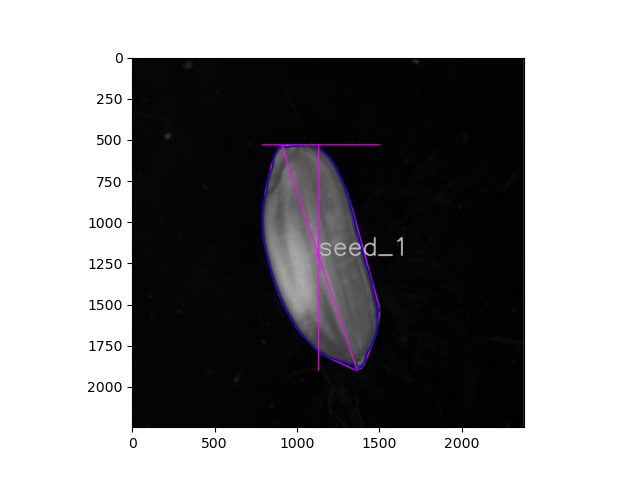

In [11]:
shape_img = pcv.analyze.size(img=img, labeled_mask=cleaned_mask, n_labels=1, label='seed')

# Record size of chalkiness area

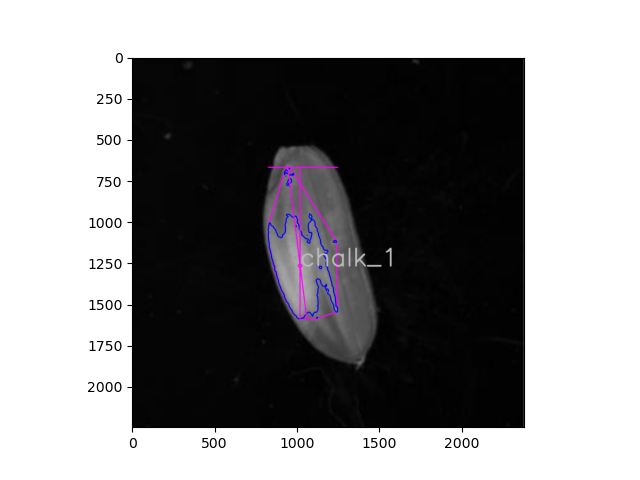

In [12]:
c_img = pcv.analyze.size(img=img, labeled_mask=chalk, n_labels=1, label='chalk')

## Store custom trait observations, like percent chalkiness 


In [13]:
perc_chalk = pcv.outputs.observations['seed_1']['area']['value'] / pcv.outputs.observations['chalk_1']['area']['value']
# Create a new measurement
pcv.outputs.add_observation(sample='seed_1', variable='percent_chalky', 
                            trait='percent of rice detected to be chalky',
                            method='ratio of pixels', scale='percent', datatype=float,
                            value=perc_chalk, label='percent')


## Save results 

In [14]:
pcv.outputs.save_results(args.result) 